In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as hg

import matplotlib.pyplot as plt
import time

key = jr.key(137)

# Test JVP and VJP

In [2]:
# Generate points
n_points = 10_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]

# Define the covariance
covariance = hg.covariance.test_cov_sampled()

In [3]:
# Random excitations
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))

t1 = time.time()
values = hg.generate_refine(graph, covariance, xi, cuda=False).block_until_ready()
t2 = time.time()
values_cuda = hg.generate_refine(graph, covariance, xi, cuda=True).block_until_ready()
t3 = time.time()
print(f"Cuda time: {1000*(t3 - t2):.2f} ms")
print(f"Jax time: {1000*(t2 - t1):.2f} ms")

Cuda time: 25.04 ms
Jax time: 1529.06 ms


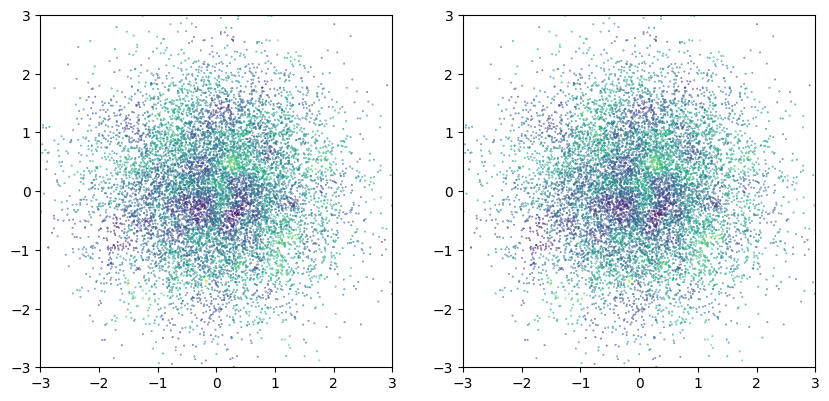

In [4]:
# Plot
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values, s=0.1, cmap='viridis')
axes[1].scatter(*points.T, c=values_cuda, s=0.1, cmap='viridis')
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
plt.show()

In [5]:
func = Partial(hg.generate_refine, graph, covariance, cuda=False)
func_cuda = Partial(hg.generate_refine, graph, covariance, cuda=True)

In [6]:
_, dv = jax.jvp(func, (xi,), (jnp.ones_like(xi),))
dv[1023:]

Array([1.7691066, 2.1496701, 2.4173226, ..., 3.1851463, 3.0715654,
       3.9245954], dtype=float32)

In [7]:
_, dv_cuda = jax.jvp(func_cuda, (xi,), (jnp.ones_like(xi),))
dv_cuda[1023:]

Array([1.7691318, 2.149669 , 2.4173331, ..., 3.1851625, 3.0715723,
       3.923375 ], dtype=float32)

In [8]:
primals_out, vjp_func = jax.vjp(func, xi)
vjp_eval = vjp_func(jnp.ones_like(xi))
vjp_eval[0][1023:]

Array([6.1499257 , 3.2766693 , 5.1555824 , ..., 0.0292113 , 0.01305182,
       0.03993472], dtype=float32)

In [9]:
primals_out, vjp_func = jax.vjp(func_cuda, xi)
vjp_eval_cuda = vjp_func(jnp.ones_like(xi))
vjp_eval_cuda[0][1023:]

Array([6.1499596 , 3.2767003 , 5.1555448 , ..., 0.02921028, 0.01305411,
       0.03995263], dtype=float32)

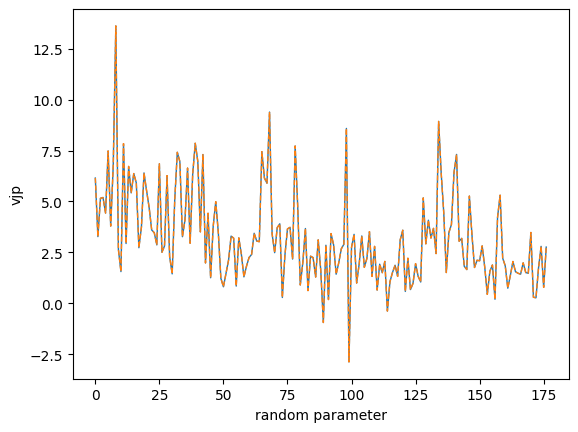

In [10]:
plt.plot(vjp_eval[0][1023:1200:], lw=1)
plt.plot(vjp_eval_cuda[0][1023:1200], lw=1, ls='--')
plt.gca().set(xlabel='random parameter', ylabel='vjp')
plt.show()

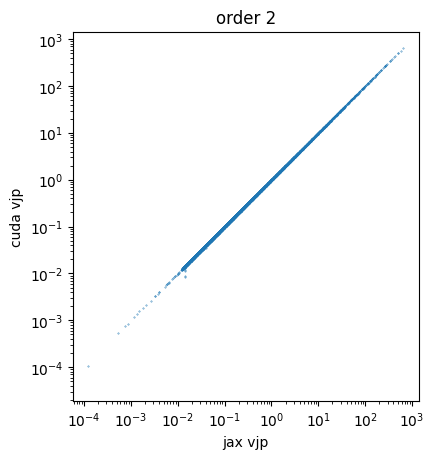

In [11]:
plt.scatter(vjp_eval[0], vjp_eval_cuda[0], s=0.1)
plt.gca().set(aspect='equal', xscale='log', yscale='log', xlabel='jax vjp', ylabel='cuda vjp', title='order 2')
plt.show()

# Test adjoint condition

In [17]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]

# Define the covariance
covariance = hg.covariance.test_cov_sampled()

In [18]:
func = Partial(hg.generate_refine, graph, covariance, cuda=True)

In [19]:
key, k1, k2, k3 = jr.split(key, 4)
xi = jr.normal(k1, (n_points,))
xi_tangent = jr.normal(k2, (n_points,))
values_tangent = jr.normal(k3, (n_points,))

In [20]:
jnp.dot(values_tangent, jax.jvp(func, (xi,), (xi_tangent,))[1])

Array(199.4231, dtype=float32)

In [21]:
jnp.dot(xi_tangent, jax.vjp(func, xi)[1](values_tangent)[0])

Array(199.41953, dtype=float32)

# Test gradient optimization


In [27]:
import optax
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [28]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]
n_initial = int(graph[1][0])

# Define the covariance
covariance = hg.covariance.test_cov_sampled()

In [29]:
# Generate truth
key, k1 = jr.split(key)
xi_true = jr.normal(k1, (n_points,))
values_true = hg.generate_refine(graph, covariance, xi_true, cuda=True).block_until_ready()
values_true

Array([ 0.9601499 ,  0.30877587,  0.78612787, ..., -0.68693376,
       -0.68144464, -0.24805833], dtype=float32)

In [30]:
# Set up optimization
optimizer = optax.adam(0.03)
key, k1 = jr.split(key)
xi_guess = jr.normal(k1, (n_points,))

In [31]:
# Mean squared error loss
n_initial = int(graph[1][0])

def loss_fn(xi):
    values = hg.generate_refine(graph, covariance, xi, cuda=True)
    return jnp.sum(jnp.square(values - values_true))

# # Optimization step
@jax.jit
def step(carry):
    xi, optimizer_state = carry
    loss, grad = jax.value_and_grad(loss_fn)(xi)
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    xi = optax.apply_updates(xi, updates)
    return (xi, optimizer_state), loss

100%|██████████| 200/200 [00:03<00:00, 52.80it/s]


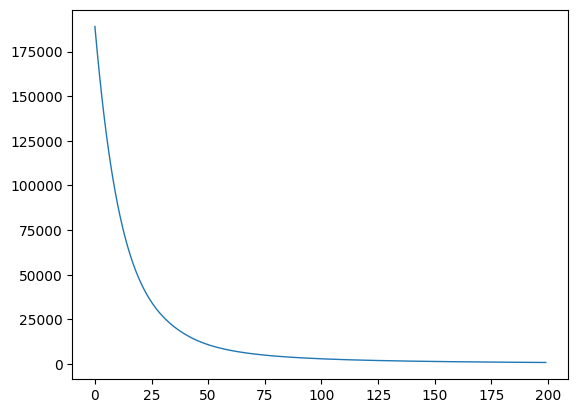

In [34]:
# Optimize!
xi = xi_guess
optimizer_state = optimizer.init(xi_guess)
loss_hist = []
values_hist = []

for i in tqdm(range(200)):
    (xi, optimizer_state), loss = step((xi, optimizer_state))
    loss_hist.append(float(loss))
    values_hist.append(hg.generate_refine(graph, covariance, xi, cuda=True))

values = hg.generate_refine(graph, covariance, xi, cuda=True).block_until_ready()

plt.plot(loss_hist, lw=1)
plt.show()

In [ ]:
# Animate optimization
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values_true, s=1, cmap='viridis', vmin=-3, vmax=3)
s = axes[1].scatter(*points.T, c=values_hist[0], s=1, cmap='viridis', vmin=-3, vmax=3)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))

def update(i):
    s.set_array(values_hist[i])
    return s,

ani = FuncAnimation(fig, update, frames=jnp.arange(0, len(values_hist), 10), blit=True, interval=1000/10)
plt.close()
HTML(ani.to_html5_video())

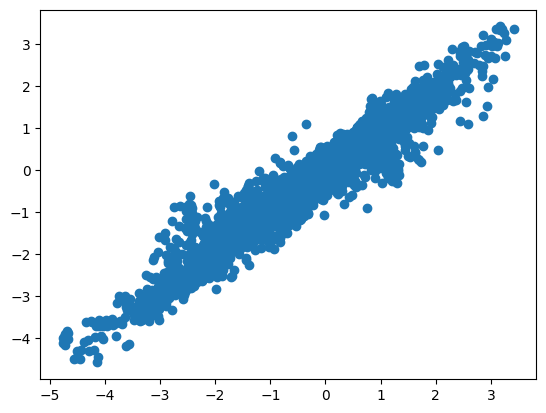

In [ ]:
plt.scatter(values_true, values)

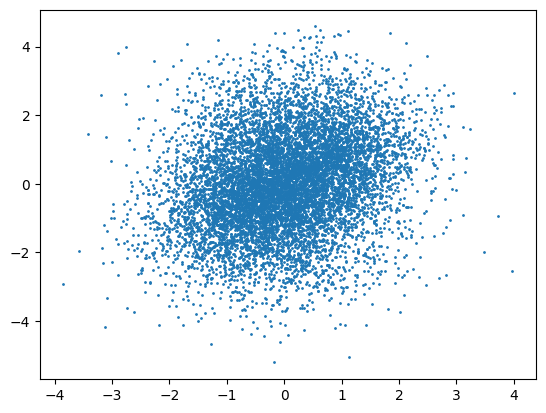

In [ ]:
plt.scatter(xi_true, xi, s=1)

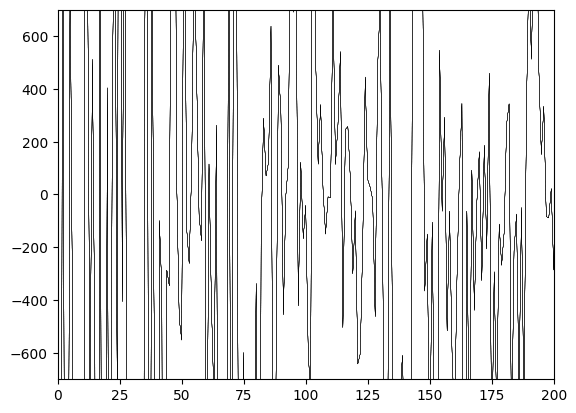

In [26]:
func = Partial(hg.generate_refine, graph, covariance, cuda=False)
func_vjp = jax.vjp(func, xi_guess)[1]

def loss_fn(xi):
    values = func(xi)
    return jnp.sum(values**2)
loss_grad = jax.grad(loss_fn)

for i in range(10):
    # arr = 2 * func_vjp(func(xi_guess))[0]
    arr = loss_grad(xi_guess)
    plt.plot(arr, lw=.1, c='k')

plt.gca().set(xlim=(0,200), ylim=(-700, 700))
plt.show()

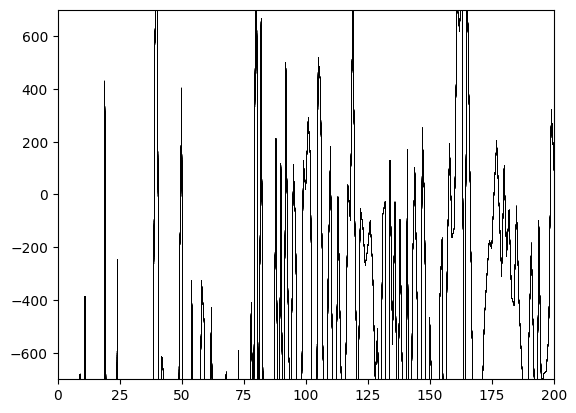

In [19]:
func = Partial(hg.generate_refine, graph, covariance, cuda=True)
func_vjp = jax.vjp(func, xi_guess)[1]

def loss_fn(xi):
    values = func(xi)
    return jnp.sum(values**2)
loss_grad = jax.grad(loss_fn)

for i in range(100):
    arr = loss_grad(xi_guess)
    plt.plot(arr, lw=.1, c='k')
plt.gca().set(xlim=(0,200), ylim=(-700, 700))
plt.show()